In [2]:
import numpy as np
import math
import cv2
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.text as mtext

from skimage.measure import label, regionprops

%matplotlib inline

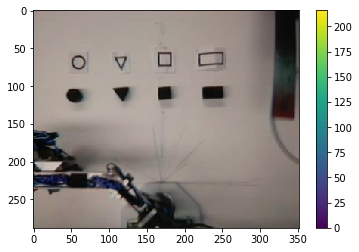

In [29]:
frame = np.load('../images/sample-1.npy')
plt.imshow(frame)
plt.colorbar()
plt.show()

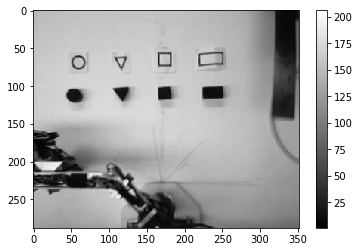

In [30]:
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

plt.imshow(gray, cmap='gray')
plt.colorbar()
plt.show()

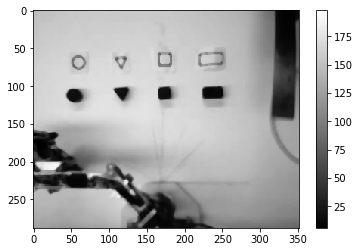

In [31]:
filtered = cv2.medianBlur(gray, 5)

plt.imshow(filtered, cmap='gray')
plt.colorbar()
plt.show()

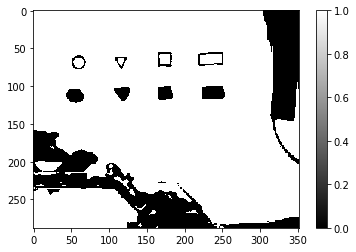

In [40]:
threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1] / 255

plt.imshow(threshold, cmap='gray')
plt.colorbar()
plt.show()

labeled 17 regions


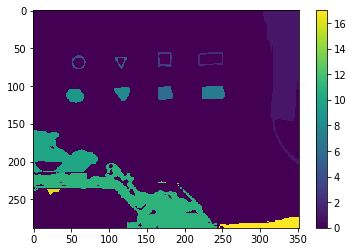

In [41]:
labeled_image = label(threshold, background=1)
print 'labeled {} regions'.format(labeled_image.max())
ax = plt.imshow(labeled_image, vmin=labeled_image.min(), vmax=labeled_image.max())
plt.colorbar()
plt.show()

In [42]:
regions =  regionprops(labeled_image)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

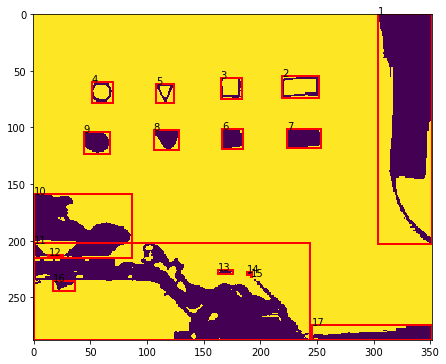

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(threshold)

for region in regions:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.annotate('{}'.format(region.label), (minc, minr))
plt.colorbar()
plt.show()

In [131]:
LABELS = {
    1: 'rectangle_slot',
    2: 'square_slot',
    3: 'circle_slot',
    4: 'triangle_slot',
    5: 'square_block',
    6: 'rectangle_block',
    7: 'triangle_block',
    8: 'circle_block'
}

def parse_region(region):
    return {
        'area': region.area,
        'orientation': region.orientation,
        'perimeter': region.perimeter,
        'minor_axis': region.minor_axis_length,
        'major_axis': region.major_axis_length,
        'convex_area': region.convex_area,
        'filled_area': region.filled_area, 
        'image': region.image
    }
    

region_stats = pd.DataFrame()
for r in regions:
    region = parse_region(r)
    region['label'] = LABELS[int(r.label)]
    region_stats = region_stats.append(region, ignore_index=True)

region_stats

,area,convex_area,filled_area,image,label,major_axis,minor_axis,orientation,perimeter
0,194.0,586.0,561.0,"[[False, False, False, False, False, False, Fa...",rectangle_slot,45.833759,26.666505,0.094125,163.692388
1,153.0,355.0,339.0,"[[False, True, True, True, True, True, True, T...",square_slot,26.813371,25.947988,0.058304,116.142136
2,122.0,276.0,270.0,"[[False, False, False, False, False, False, Fa...",circle_slot,23.313617,22.795519,0.528066,75.627417
3,94.0,161.0,156.0,"[[True, True, True, True, True, True, True, Tr...",triangle_slot,18.884162,17.215186,-1.196367,78.763456
4,306.0,317.0,306.0,"[[False, False, False, False, False, False, Fa...",square_block,20.758910,19.380223,0.155052,65.313708
5,479.0,488.0,479.0,"[[False, False, False, False, False, True, Tru...",rectangle_block,33.307525,18.836044,0.028858,85.899495
6,269.0,279.0,269.0,"[[False, False, False, False, False, False, Fa...",triangle_block,20.873894,17.945988,-0.406693,64.284271
7,343.0,354.0,343.0,"[[False, False, False, False, False, True, Tru...",circle_block,23.596829,18.518534,-0.256290,67.698485


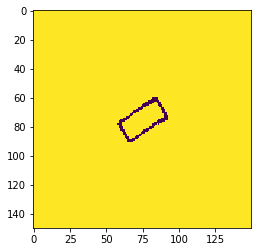

In [225]:
def rotate_scale_image(mat, angle, scale):
    height, width = mat.shape[:2]
    image_center = (width / 2, height / 2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1)

    radians = math.radians(angle)
    sin = math.sin(radians)
    cos = math.cos(radians)
    bound_w = int((height * abs(sin)) + (width * abs(cos)))
    bound_h = int((height * abs(cos)) + (width * abs(sin)))

    rotation_mat[0, 2] += ((bound_w / 2) - image_center[0])
    rotation_mat[1, 2] += ((bound_h / 2) - image_center[1])

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    scale += 1
    rotated_mat = cv2.resize(rotated_mat, (0,0), fx=scale, fy=scale) 
   
    horizontal_padding = (150 - rotated_mat.shape[0]) / 2
    vertical_padding = (150 - rotated_mat.shape[1])/2
        
    rotated_mat = cv2.copyMakeBorder(rotated_mat, horizontal_padding, horizontal_padding, vertical_padding, vertical_padding, cv2.BORDER_CONSTANT, value=0)
    rotated_mat = np.abs(1 - rotated_mat)

    return rotated_mat 
    
plt.imshow(rotate_scale_image(region_stats.iloc[0]['image'].astype(np.uint8), 30, -0.01))

# Randomize Rotation and Scale

training_set = pd.DataFrame()

def rotate_and_parse_region(image, angle, scale):
    image = rotate_scale_image(image, angle, scale)
    labels = label(image, background=1)
    region = regionprops(labels)
    if len(region) != 1:
        raise
    return parse_region(region[0])
    

for index, region in region_stats.iterrows():
    for angle in range(0, 180):
        angle *= 2
        scale = 0.05 - 0.025*np.random.rand()
        try:
            r = rotate_and_parse_region(region['image'].astype(np.uint8), angle, scale)
        except:
            continue
        r['label'] = region.label
        r['angle'] = angle
        r['scale'] = scale
        r.pop('image', None)
        
        training_set = training_set.append(r, ignore_index=True)


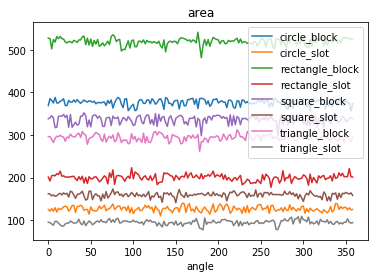

In [259]:
def plot_feature(feature):
    t = training_set.set_index('angle')
    t.groupby('label')[feature].plot(legend=True, title=feature)

plot_feature('area')

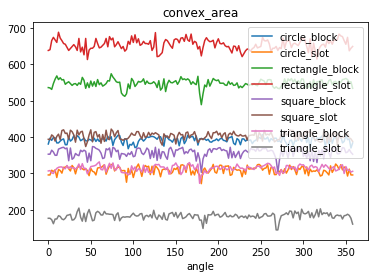

In [260]:
plot_feature('convex_area')

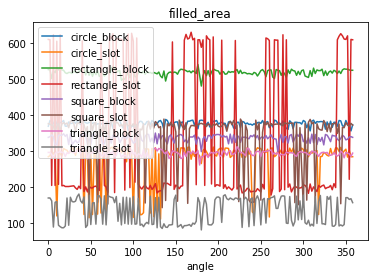

In [261]:
plot_feature('filled_area')

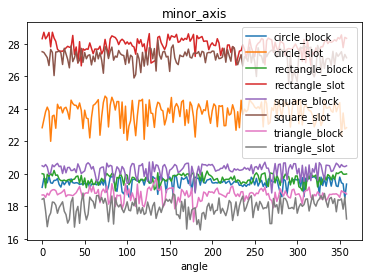

In [262]:
plot_feature('minor_axis')

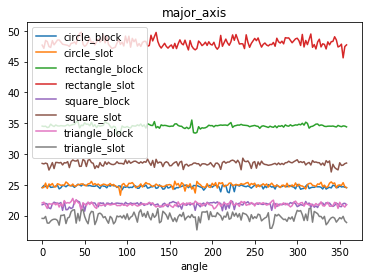

In [263]:
plot_feature('major_axis')

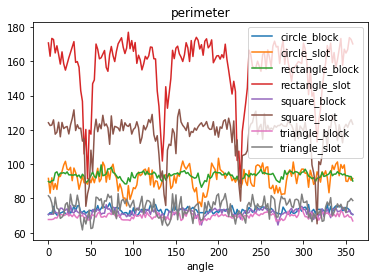

In [264]:
plot_feature('perimeter')

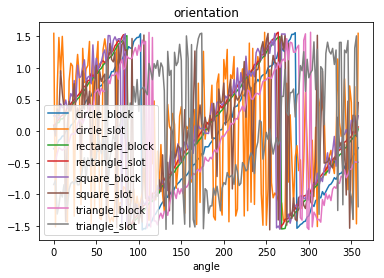

In [265]:
plot_feature('orientation')

# Classification

In [290]:
import sklearn.naive_bayes

model = sklearn.naive_bayes.GaussianNB()

In [291]:
features = np.array([
    training_set['area'],
    training_set['minor_axis'],
    training_set['major_axis'],
    training_set['convex_area'],
    training_set['perimeter'],
    training_set['filled_area']
]).transpose()

labels = np.array(training_set['label'])

In [292]:
model.fit(features, labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [293]:
model.theta_

array([[376.44444444,  19.45693483,  24.70014815, 392.32222222,
         73.05388363, 376.44444444],
       [126.57777778,  23.79317358,  24.94343141, 309.70555556,
         91.74404017, 279.06111111],
       [518.79444444,  19.69390758,  34.54541076, 547.70555556,
         93.42711234, 518.79444444],
       [200.03592814,  27.91457547,  48.00627421, 654.77844311,
        157.40274683, 332.39520958],
       [335.88333333,  20.25826993,  21.82847901, 357.65      ,
         71.88872851, 335.88333333],
       [159.44134078,  27.20324503,  28.45970148, 403.5027933 ,
        117.42611102, 345.86592179],
       [293.57777778,  18.72740224,  21.83370316, 314.21111111,
         69.71633694, 293.57777778],
       [ 94.83888889,  17.94939498,  19.77939098, 183.32222222,
         74.57648025, 133.1       ]])

In [297]:
model.classes_

array(['circle_block', 'circle_slot', 'rectangle_block', 'rectangle_slot',
       'square_block', 'square_slot', 'triangle_block', 'triangle_slot'],
      dtype='|S15')

In [301]:
model.predict([features[0]])

array(['rectangle_slot'], dtype='|S15')